# (1) Dataset Visualization

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


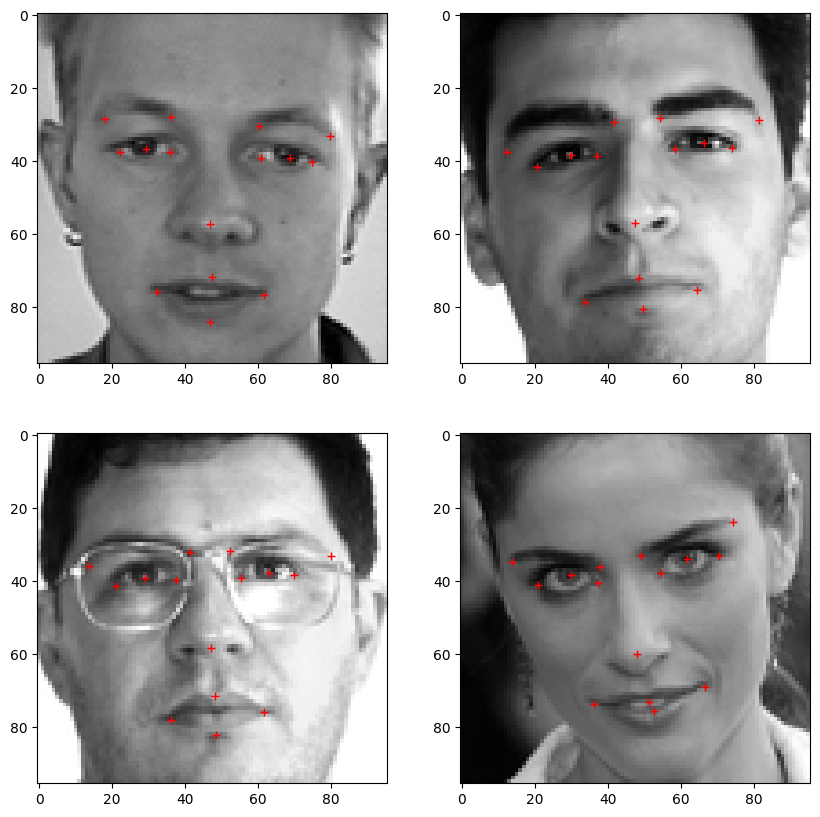

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# Set the random seed for TensorFlow
tf.random.set_seed(101)

# load the data
data = io.loadmat("face_landmark.mat")
images = data["images"]
landmarks = data["landmarks"]

print("im_shape:", images.shape)
print("landmarks_shape:", landmarks.shape)

np.random.seed(101)

fig, ax = plt.subplots(2, 2, figsize=(10,10))  # create a 2x2 grid of subplots
ax = ax.ravel()

for i in range(4):  # loop over the 4 subplots
    id = np.random.randint(len(images))  # generate a random index
    im = images[id]
    keypoints = landmarks[id]

    ax[i].imshow(im, cmap="gray")
    for point in keypoints:
        ax[i].plot(point[0], point[1], "r+")

plt.show()

# (2) Preprocessing

### (2)-1. Data_split: train(60%), validation(20%), test(20%)

In [2]:
from sklearn.model_selection import train_test_split

# 60% training, 40% for validation/testing
train_images, val_test_images, train_landmarks, val_test_landmarks = train_test_split(images, landmarks, test_size=0.4, random_state=101)

# Split the 40% equally to validation and testing (20% each)
val_images, test_images, val_landmarks, test_landmarks = train_test_split(val_test_images, val_test_landmarks, test_size=0.5, random_state=101)

# reshape landmarks
train_landmarks = train_landmarks.reshape(-1, 30)
val_landmarks = val_landmarks.reshape(-1, 30)
test_landmarks = test_landmarks.reshape(-1, 30)

print("Training set:", train_images.shape, train_landmarks.shape)
print("Validation set:", val_images.shape, val_landmarks.shape)
print("Testing set:", test_images.shape, test_landmarks.shape)

Training set: (1284, 96, 96) (1284, 30)
Validation set: (428, 96, 96) (428, 30)
Testing set: (428, 96, 96) (428, 30)


### (2)-2. Normalization & Reshaping

In [3]:
# Normalization
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Scale landmarks
train_landmarks = train_landmarks / 96.0
val_landmarks = val_landmarks / 96.0
test_landmarks = test_landmarks / 96.0

# Reshaping
train_images = train_images.reshape(-1, 96, 96, 1)
val_images = val_images.reshape(-1, 96, 96, 1)
test_images = test_images.reshape(-1, 96, 96, 1)

print("After preprocessing:")
print("Training set:", train_images.shape, train_landmarks.shape)
print("Validation set:", val_images.shape, val_landmarks.shape)
print("Testing set:", test_images.shape, test_landmarks.shape)

After preprocessing:
Training set: (1284, 96, 96, 1) (1284, 30)
Validation set: (428, 96, 96, 1) (428, 30)
Testing set: (428, 96, 96, 1) (428, 30)


In [4]:
# Find the range of the landmarks coordinates
landmarks_range_train = np.ptp(train_landmarks, axis=0)
landmarks_range_val = np.ptp(val_landmarks, axis=0)
landmarks_range_test = np.ptp(test_landmarks, axis=0)

print("Range of x coordinates in train data: ", landmarks_range_train[::2])
print("Range of y coordinates in train data: ", landmarks_range_train[1::2])

print("Range of x coordinates in validation data: ", landmarks_range_val[::2])
print("Range of y coordinates in validation data: ", landmarks_range_val[1::2])

print("Range of x coordinates in test data: ", landmarks_range_test[::2])
print("Range of y coordinates in test data: ", landmarks_range_test[1::2])

# Find the range of the image dimensions
image_range = np.array([1, 1])  # Since all images are normalized to [0,1]
print("Image range: ", image_range)

Range of x coordinates in train data:  [0.24770904 0.2455475  0.21195495 0.3001253  0.18858916 0.30204564
 0.25743538 0.32714456 0.2068975  0.37343583 0.33728275 0.42601708
 0.4094518  0.2847543  0.30615094]
Range of y coordinates in train data:  [0.23228565 0.21766388 0.20833561 0.24378961 0.19413832 0.23512885
 0.2545213  0.32990867 0.23926936 0.32790154 0.35869095 0.3921914
 0.38284343 0.3874718  0.40184045]
Range of x coordinates in validation data:  [0.2762287  0.16548106 0.23932487 0.30294508 0.18124372 0.15884888
 0.3098283  0.3554799  0.25662467 0.17586568 0.38993657 0.29606566
 0.28550935 0.28382248 0.28200212]
Range of y coordinates in validation data:  [0.1715844  0.20588335 0.15711609 0.23690692 0.17125025 0.24250722
 0.20981152 0.33408678 0.20284823 0.28002593 0.29478893 0.30648702
 0.26343924 0.33945024 0.28691435]
Range of x coordinates in test data:  [0.12574387 0.14884283 0.12396657 0.18157959 0.13101271 0.17166944
 0.21898112 0.24192876 0.18511435 0.2634657  0.2624755

# (3) CNN Model

### (3)-1. Model Architecture

In [6]:
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def create_model():
    inputs = Input(shape=(96, 96, 1))

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu', 
               kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(inputs)
    x = MaxPool2D(pool_size=2, strides=2)(x)

    x = Conv2D(32, kernel_size=3, padding='same', activation='relu', 
               kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
    x = MaxPool2D(pool_size=2, strides=2)(x)

    x = Conv2D(64, kernel_size=3, padding='same', activation='relu', 
               kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
    x = MaxPool2D(pool_size=2, strides=2)(x)

    x = Conv2D(64, kernel_size=3, padding='same', activation='relu', 
               kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
    x = MaxPool2D(pool_size=2, strides=2)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)

    # 15 facial landmarks * 2 for the x and y coordinates = 30
    outputs = Dense(30)(x)

    return Model(inputs=inputs, outputs=outputs)

model = create_model()

Metal device set to: Apple M2 Pro


### (3)-2. Loss-function: L2-loss

In [7]:
def l2_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

### (3)-3. Model fit

In [8]:
# Set learning rate schedule
lr_schedule = LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

model.compile(optimizer='adam', loss=l2_loss)

### (3)-4. Model train: Creating 'Callbacks' & training

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Create callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

callbacks_list = [checkpoint, early_stop]

# Train the model
history = model.fit(train_images, train_landmarks, validation_data=(val_images, val_landmarks), 
                    batch_size=32, epochs=100, callbacks=callbacks_list)

# Load the best model
model.load_weights('best_model.h5')

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 33.3018
Epoch 1: val_loss improved from inf to 9.56273, saving model to best_model.h5
41/41 [==============================] - 2s 32ms/step - loss: 33.3018 - val_loss: 9.5627
Epoch 2/100
 6/41 [===>..........................] - ETA: 0s - loss: 8.2664

/Users/sh_oh/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/41 [===========================>..] - ETA: 0s - loss: 3.9417
Epoch 2: val_loss improved from 9.56273 to 0.90647, saving model to best_model.h5
41/41 [==============================] - 1s 26ms/step - loss: 3.8595 - val_loss: 0.9065
Epoch 3/100
38/41 [==========================>...] - ETA: 0s - loss: 0.4912
Epoch 3: val_loss improved from 0.90647 to 0.30012, saving model to best_model.h5
41/41 [==============================] - 1s 25ms/step - loss: 0.4815 - val_loss: 0.3001
Epoch 4/100
40/41 [============================>.] - ETA: 0s - loss: 0.2790
Epoch 4: val_loss improved from 0.30012 to 0.26740, saving model to best_model.h5
41/41 [==============================] - 1s 26ms/step - loss: 0.2789 - val_loss: 0.2674
Epoch 5/100
39/41 [===========================>..] - ETA: 0s - loss: 0.2665
Epoch 5: val_loss improved from 0.26740 to 0.26511, saving model to best_model.h5
41/41 [==============================] - 1s 24ms/step - loss: 0.2664 - val_loss: 0.2651
Epoch 6/100
38/41 [=========

### (3)-5. calculate validation loss & prediction error

14/14 [==============================] - 0s 12ms/step - loss: 0.2487
Validation loss:  0.24874617159366608
14/14 [==============================] - 0s 8ms/step
Validation prediction error:  0.024081113


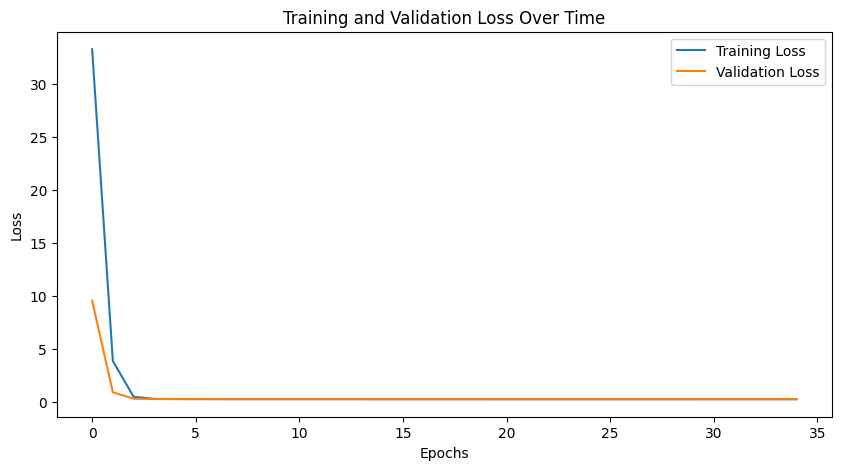

In [10]:
# Calculate the validation loss
val_loss = model.evaluate(val_images, val_landmarks)
print("Validation loss: ", val_loss)

# Calculate the prediction error on the validation set
val_predictions = model.predict(val_images)
prediction_error = np.mean(np.abs(val_predictions - val_landmarks))
print("Validation prediction error: ", prediction_error)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()